In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Training data

In [3]:
# Define dataset path
train_dir = r"E:\Medical waste classification\Working\Split Dataset\Train"


In [4]:
# Load MobileNetV2 and ResNet50 without the top classification layer
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


In [5]:
def extract_and_fuse_features(directory, mobilenet_model, resnet_model):
    fused_features = []
    labels = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        
        if not os.path.isdir(class_path): 
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                
                # Extract features from MobileNetV2
                mobilenet_features = mobilenet_model.predict(mobilenet_preprocess(img_array)).flatten()

                # Extract features from ResNet50
                resnet_features = resnet_model.predict(resnet_preprocess(img_array)).flatten()

                # Fuse features from both models
                fused_feature = np.concatenate((mobilenet_features, resnet_features))

                fused_features.append(fused_feature)
                labels.append(class_name)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    return np.array(fused_features), np.array(labels)


In [6]:
# Extract and fuse features
fused_features, labels = extract_and_fuse_features(train_dir, mobilenet_model, resnet_model)

# Display shape of extracted data
print("Extracted Fused Features Shape:", fused_features.shape)
print("Number of Labels:", len(labels))


1/1 [==============================] - 0s 18ms/step
Error processing E:\Medical waste classification\Working\Split Dataset\Train\(BT) Body Tissue or Organ\kk.docx: cannot identify image file <_io.BytesIO object at 0x000001F8B10721D0>
1/1 [==============================] - 0s 27ms/step
Extracted Fused Features Shape: (4125, 3328)
Number of Labels: 4125


In [7]:
# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Save the label encoder for later use
joblib.dump(label_encoder, 'label_encoder.pkl')

# Display unique labels
print("Unique Classes:", label_encoder.classes_)


Unique Classes: ['(BT) Body Tissue or Organ' '(GE) Glass equipment-packaging 551'
 '(ME) Metal equipment -packaging' '(OW) Organic wastes'
 '(PE) Plastic equipment-packaging' '(PP) Paper equipment-packaging'
 '(SN) Syringe needles' 'Gauze' 'Gloves' 'Mask' 'Syringe' 'Tweezers']


In [8]:
# Save fused features and labels
np.save('feature_fused_image_features.npy', fused_features)
np.save('train_image_labels.npy', encoded_labels)

print("Feature extraction and fusion completed successfully!")


Feature extraction and fusion completed successfully!


### Feature extraction from testing data

In [9]:
# Define test dataset path
test_dir = r"E:\Medical waste classification\Working\Split Dataset\Test"

# Check if the path exists
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Path {test_dir} does not exist!")


In [10]:
# Extract and fuse features from test data
test_fused_features, test_labels = extract_and_fuse_features(test_dir, mobilenet_model, resnet_model)

# Display shape of extracted test data
print("Extracted Test Fused Features Shape:", test_fused_features.shape)
print("Number of Test Labels:", len(test_labels))


1/1 [==============================] - 0s 20ms/step
Extracted Test Fused Features Shape: (890, 3328)
Number of Test Labels: 890


In [11]:
    # Load the saved label encoder
label_encoder = joblib.load('label_encoder.pkl')

# Encode test labels
encoded_test_labels = label_encoder.transform(test_labels)

# Display unique labels in test set
print("Unique Test Classes:", np.unique(encoded_test_labels))


Unique Test Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [12]:
# Save fused test features and labels
np.save('fused_test_features.npy', test_fused_features)
np.save('test_labels.npy', encoded_test_labels)

print("Test feature extraction and fusion completed successfully!")


Test feature extraction and fusion completed successfully!


### Using the Random Forest Classifier

In [2]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [3]:
# Load fused features and labels
X_train = np.load('feature_fused_image_features.npy')
y_train = np.load('train_image_labels.npy')

X_test = np.load('fused_test_features.npy')
y_test = np.load('test_labels.npy')

print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Train Data Shape: (4125, 3328)
Test Data Shape: (890, 3328)


In [4]:
# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save the trained model
joblib.dump(clf, 'random_forest_model.pkl')

print("Model training completed and saved!")


Model training completed and saved!


In [5]:
# Load the trained model
clf = joblib.load('random_forest_model.pkl')

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        78
           1       1.00      0.97      0.98        66
           2       1.00      0.95      0.98        62
           3       1.00      0.99      0.99        86
           4       1.00      1.00      1.00        67
           5       0.97      0.99      0.98        77
           6       0.96      1.00      0.98        85
           7       1.00      0.99      0.99        68
           8       1.00      1.00      1.00        77
           9       0.98      0.98      0.98        63
          10       1.00      1.00      1.00        81
          11       1.00      1.00      1.00        80

    accuracy                           0.99       890
   macro avg       0.99      0.99      0.99       890
weighted avg       0.99      0.99      0.99       890



### Validation

In [ ]:
validation_dir = "E:/Medical waste classification/Working/Split Dataset/Validation"
validation_features, validation_labels = extract_and_fuse_features(validation_dir, mobilenet_model, resnet_model)

# Save validation features
np.save('fused_validation_features.npy', validation_features)
np.save('validation_labels.npy', validation_labels)

print("Feature extraction for validation data completed!")


In [ ]:
# Load the label encoder
label_encoder = joblib.load("label_encoder.pkl")

# Encode validation labels
encoded_validation_labels = label_encoder.transform(validation_labels)

# Load the trained ML model
clf = joblib.load("random_forest_model.pkl")

print("Label encoder and trained model loaded!")


In [ ]:
# Predict using the trained ML model
predictions = clf.predict(validation_features)

# Convert predictions back to class names
predicted_labels = label_encoder.inverse_transform(predictions)

# Calculate accuracy
accuracy = accuracy_score(encoded_validation_labels, predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:\n", classification_report(encoded_validation_labels, predictions))


Validation Accuracy: 98.64%
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        77
           1       0.98      0.94      0.96        66
           2       1.00      0.98      0.99        61
           3       0.99      1.00      0.99        85
           4       1.00      1.00      1.00        67
           5       0.97      1.00      0.99        76
           6       0.99      1.00      0.99        84
           7       0.97      0.99      0.98        68
           8       1.00      1.00      1.00        76
           9       1.00      1.00      1.00        63
          10       1.00      0.99      0.99        80
          11       0.99      0.97      0.98        80

    accuracy                           0.99       883
   macro avg       0.99      0.99      0.99       883
weighted avg       0.99      0.99      0.99       883



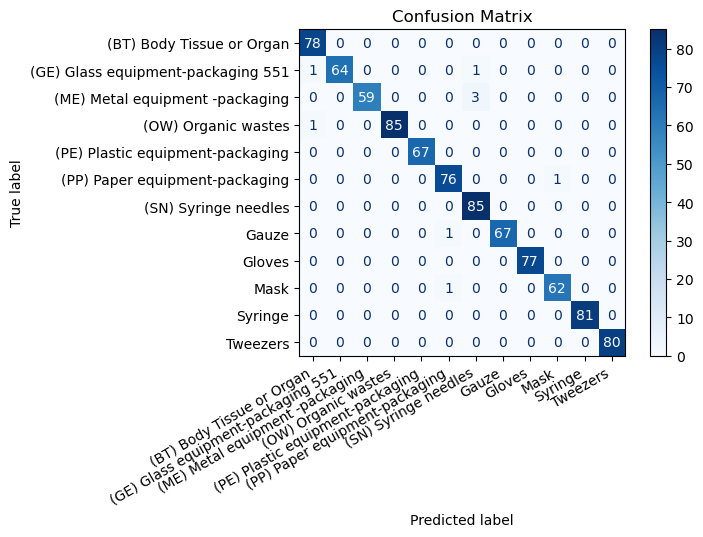

In [17]:
# Generate confusion matrix
label_encoder = joblib.load("label_encoder.pkl")
cm = confusion_matrix(y_test, y_pred)


# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.gcf().autofmt_xdate()  # Automatically rotates the labels to avoid overlap
plt.show()


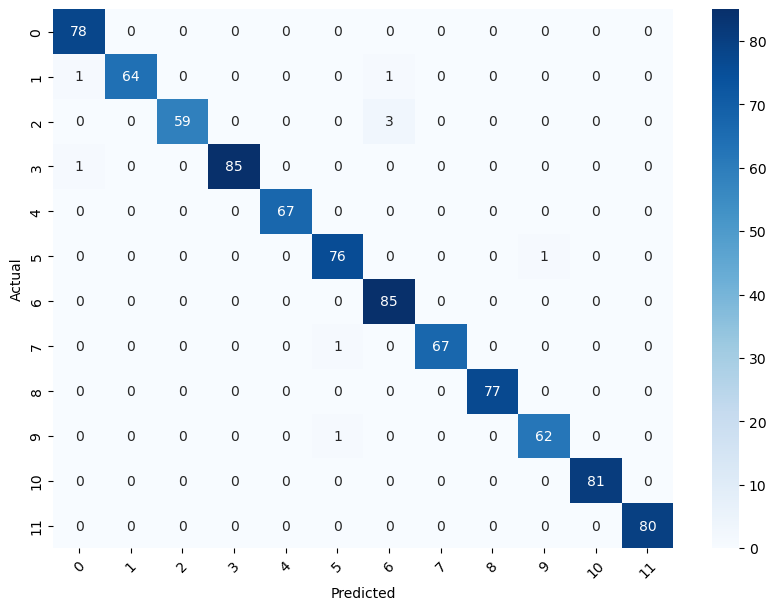

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)
